# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.69KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

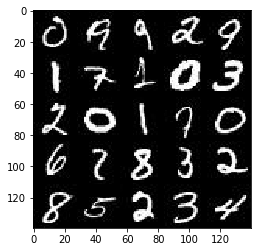

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

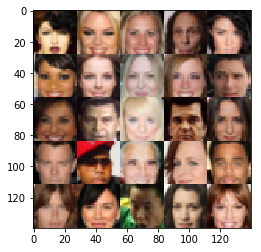

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [70]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [71]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    dis_model_real, dis_logits_real = discriminator(input_real, reuse=False)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real)))

    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [76]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
           
                # Random data for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimisers
                _ = sess.run(d_opt, feed_dict={input_real : batch_images, 
                                               input_z : batch_z, 
                                               learn_rate : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real : batch_images,
                                               input_z : batch_z, 
                                               learn_rate : learning_rate})
                
                if steps % 10 == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 1.2054
Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 8.2569
Epoch 1/2... Discriminator Loss: 1.8777... Generator Loss: 6.2130
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 2.3366
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.4391
Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 2.0119
Epoch 1/2... Discriminator Loss: 1.4571... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.8949... Generator Loss: 0.2431
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 1.5771... Generator Loss: 0.6125


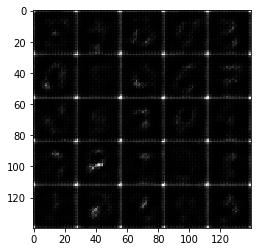

Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.4485
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 2.0317
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.9502... Generator Loss: 0.2239
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.9676


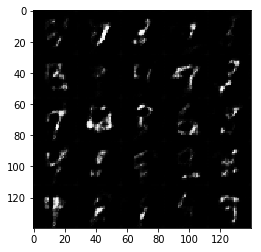

Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.3407
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.5324
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.3868
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.6530... Generator Loss: 0.6545


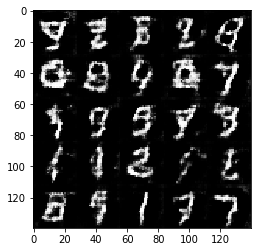

Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 2.0062... Generator Loss: 0.2367
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.7328
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.4586
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.4455


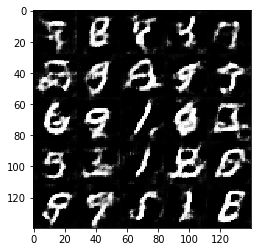

Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 1.0219
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.9606
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.0343
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.5766
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.6276


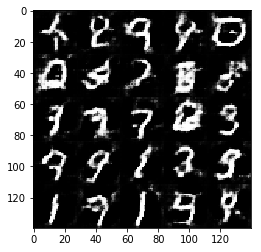

Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.5043
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.6376
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.1714
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 1.0528
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.3904
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.7603


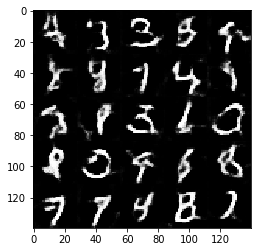

Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 0.8434


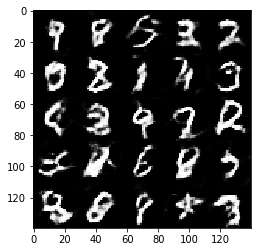

Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.0741
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 1.4833
Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 1.4405
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 1.4954


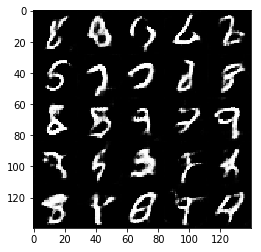

Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.0422
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.4798


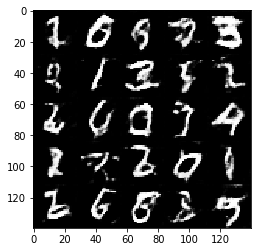

Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.3707
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 3.4163... Generator Loss: 4.1152
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.7401


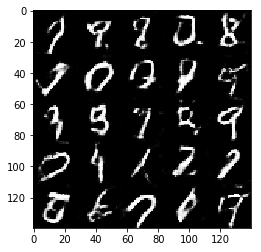

Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.4696
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.3783
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 2.1374
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.7733
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.8973


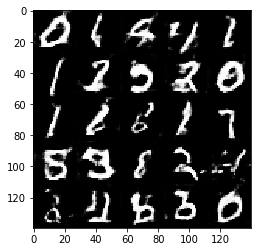

Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 1.8380
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.5767
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.4473
Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.6198... Generator Loss: 0.2977
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 0.9817


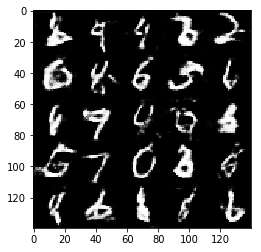

Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 0.2881
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.6340
Epoch 1/2... Discriminator Loss: 0.7581... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.4960
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.1263
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 2.4859


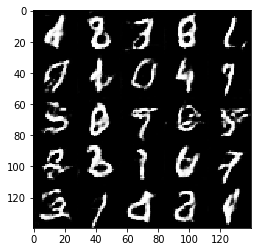

Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 0.9696
Epoch 1/2... Discriminator Loss: 0.5039... Generator Loss: 1.6079
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 0.5160
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 1.7969
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.1607
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.7099


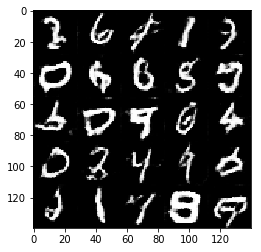

Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.5336
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 1.5425
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 1.6255... Generator Loss: 0.2863
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 0.7773... Generator Loss: 2.2669
Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 1.0142
Epoch 1/2... Discriminator Loss: 0.5962... Generator Loss: 1.2026
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 0.9276


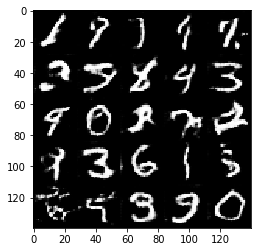

Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 1.0703
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 1.7641... Generator Loss: 0.3028
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.3711
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 0.6623... Generator Loss: 1.2453
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.3893


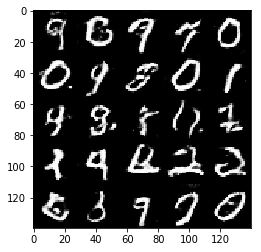

Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.1165
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 1.8053
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 1.0338
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.0834
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.4976


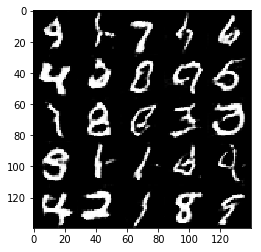

Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 0.7396... Generator Loss: 1.2728
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 1.0541
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.4297
Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 1.3128
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.4841
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.6269


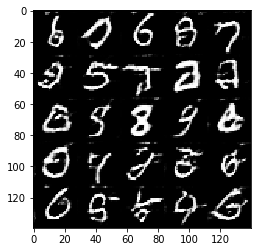

Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 0.6527... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.6601... Generator Loss: 0.3853
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 1.4119
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.9378
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 0.7801


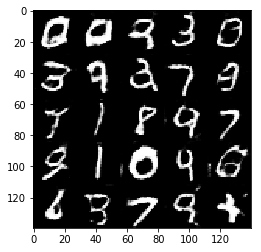

Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.4010
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.5700
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 2.0867
Epoch 2/2... Discriminator Loss: 0.3192... Generator Loss: 1.8622
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.8537
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 0.8620


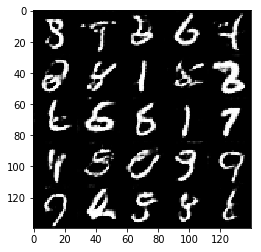

Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.2799
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 0.6719... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 0.4825... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 2.0890
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 2.1918
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 0.9082


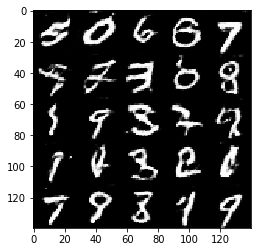

Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 1.2955
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 1.7737
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.3984
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 1.3332
Epoch 2/2... Discriminator Loss: 0.6462... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 1.4440
Epoch 2/2... Discriminator Loss: 0.4664... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.3888


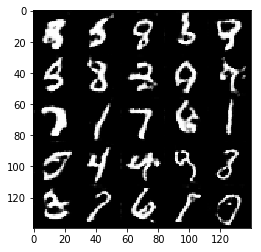

Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.5560
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 2.2591
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.3976
Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 1.4407
Epoch 2/2... Discriminator Loss: 0.4241... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 2.2692
Epoch 2/2... Discriminator Loss: 1.8491... Generator Loss: 0.2700
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 1.4285
Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 2.1471


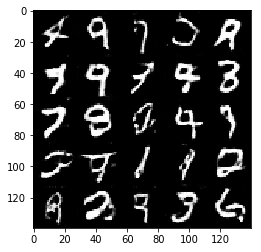

Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 1.4057
Epoch 2/2... Discriminator Loss: 0.9145... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 0.5337... Generator Loss: 1.2914
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.1888
Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 1.4418
Epoch 2/2... Discriminator Loss: 0.9642... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.6491... Generator Loss: 0.4213
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 1.8742
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 0.9044


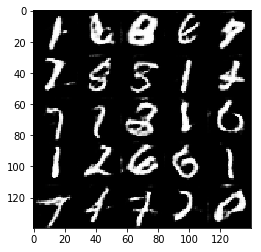

Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 0.4787... Generator Loss: 1.6036
Epoch 2/2... Discriminator Loss: 1.6383... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 1.0907
Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.4784
Epoch 2/2... Discriminator Loss: 2.0953... Generator Loss: 0.2781
Epoch 2/2... Discriminator Loss: 0.3905... Generator Loss: 1.9387


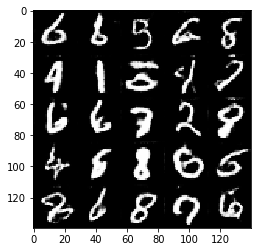

Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.3769
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.3077
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 1.6547
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.2428
Epoch 2/2... Discriminator Loss: 0.4872... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 0.4739... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 1.7502


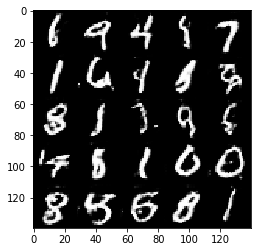

Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 1.6596
Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 1.4725
Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 2.1423
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 3.7679
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 2.1617
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 1.7689
Epoch 2/2... Discriminator Loss: 0.4263... Generator Loss: 2.1418
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 1.6703
Epoch 2/2... Discriminator Loss: 0.4787... Generator Loss: 1.5330
Epoch 2/2... Discriminator Loss: 0.4022... Generator Loss: 1.9771


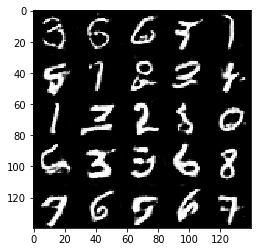

Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 0.9656
Epoch 2/2... Discriminator Loss: 0.7862... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 3.0025
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 1.7307
Epoch 2/2... Discriminator Loss: 0.5521... Generator Loss: 1.1175
Epoch 2/2... Discriminator Loss: 0.2746... Generator Loss: 2.1543
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 0.4454... Generator Loss: 1.7538
Epoch 2/2... Discriminator Loss: 0.6348... Generator Loss: 1.1010


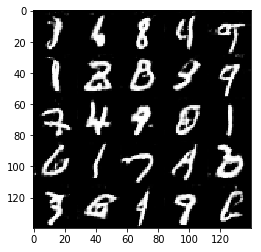

Epoch 2/2... Discriminator Loss: 1.6511... Generator Loss: 0.4701
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 0.3455... Generator Loss: 1.6271
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 2.7312
Epoch 2/2... Discriminator Loss: 1.8255... Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 0.4220... Generator Loss: 1.5683
Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 1.5096


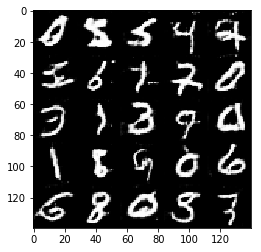

Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 1.7602
Epoch 2/2... Discriminator Loss: 0.2727... Generator Loss: 2.1807
Epoch 2/2... Discriminator Loss: 0.6456... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 1.4383
Epoch 2/2... Discriminator Loss: 0.8191... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 1.7239
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.6091
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 1.2044
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 1.9307
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.4142


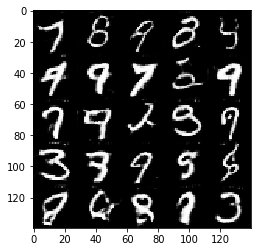

Epoch 2/2... Discriminator Loss: 0.4099... Generator Loss: 1.7683
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 3.1081
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 0.2615... Generator Loss: 2.2313
Epoch 2/2... Discriminator Loss: 0.2522... Generator Loss: 2.0593
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 1.6262
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 1.5787
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.0366


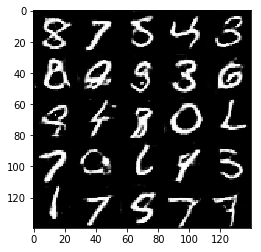

Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 1.2567
Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 2.5673
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 2.6805
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 1.3780
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 1.4703
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.2741
Epoch 2/2... Discriminator Loss: 0.4591... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.6227


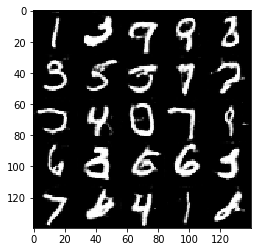

Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 1.6969
Epoch 2/2... Discriminator Loss: 0.3879... Generator Loss: 2.0878
Epoch 2/2... Discriminator Loss: 0.5399... Generator Loss: 1.5749
Epoch 2/2... Discriminator Loss: 0.4687... Generator Loss: 1.5346
Epoch 2/2... Discriminator Loss: 0.3049... Generator Loss: 1.8331
Epoch 2/2... Discriminator Loss: 0.3846... Generator Loss: 2.3894
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.4791


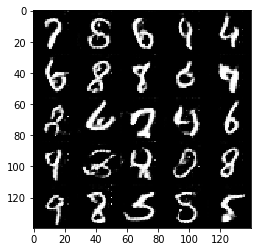

Epoch 2/2... Discriminator Loss: 1.7406... Generator Loss: 0.3403
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 0.2654... Generator Loss: 2.3635
Epoch 2/2... Discriminator Loss: 0.6506... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.5028... Generator Loss: 1.3417
Epoch 2/2... Discriminator Loss: 0.4304... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 0.2821... Generator Loss: 2.0111
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 1.6173


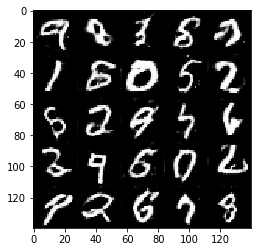

Epoch 2/2... Discriminator Loss: 0.1801... Generator Loss: 3.5147
Epoch 2/2... Discriminator Loss: 0.4470... Generator Loss: 1.5578
Epoch 2/2... Discriminator Loss: 0.2341... Generator Loss: 2.1423
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.1446
Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 1.9247
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 0.3511... Generator Loss: 1.8666
Epoch 2/2... Discriminator Loss: 0.2848... Generator Loss: 2.7683
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 1.5897


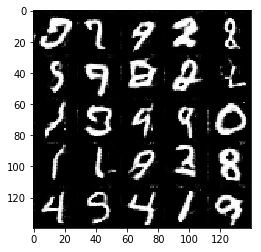

Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 1.8554
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 1.8372
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 1.8468
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.1413
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 0.6489... Generator Loss: 1.3959
Epoch 2/2... Discriminator Loss: 0.4652... Generator Loss: 2.8682
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 0.9760


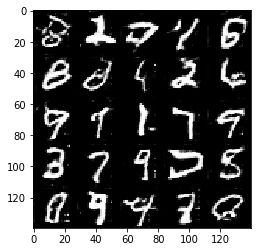

Epoch 2/2... Discriminator Loss: 0.3440... Generator Loss: 1.6181
Epoch 2/2... Discriminator Loss: 0.3872... Generator Loss: 1.5386
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 2.8699... Generator Loss: 0.0934
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.0836
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 0.2375... Generator Loss: 2.3283
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.0930


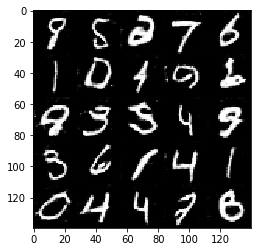

Epoch 2/2... Discriminator Loss: 0.3755... Generator Loss: 2.1867
Epoch 2/2... Discriminator Loss: 0.5414... Generator Loss: 1.8932
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 0.2744... Generator Loss: 1.9232
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 1.6005


In [77]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2191... Generator Loss: 8.4033
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 14.0882
Epoch 1/1... Discriminator Loss: 0.0885... Generator Loss: 12.1072
Epoch 1/1... Discriminator Loss: 1.9555... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 2.2037
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 3.1694
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 2.3475


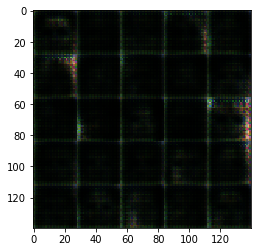

Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 7.7199
Epoch 1/1... Discriminator Loss: 0.3112... Generator Loss: 2.4550
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 3.4526
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 3.1031
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.4176


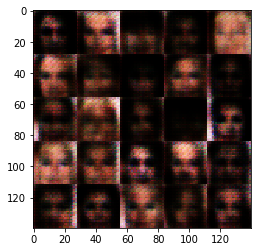

Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 2.3222... Generator Loss: 0.1816
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 4.2038
Epoch 1/1... Discriminator Loss: 2.2065... Generator Loss: 3.4097
Epoch 1/1... Discriminator Loss: 1.8381... Generator Loss: 0.2753
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.7783


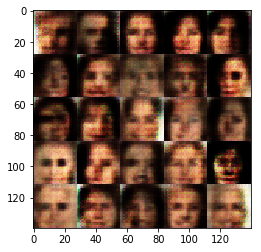

Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 3.2040... Generator Loss: 0.1032
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 3.8035
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.0875
Epoch 1/1... Discriminator Loss: 0.2845... Generator Loss: 2.7167
Epoch 1/1... Discriminator Loss: 2.2454... Generator Loss: 0.1611
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 2.7843
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.4038


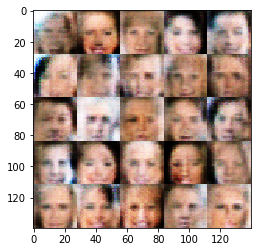

Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.5546
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 4.8387
Epoch 1/1... Discriminator Loss: 2.9228... Generator Loss: 0.0831
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 2.1938... Generator Loss: 2.6280
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 3.3531
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.3195


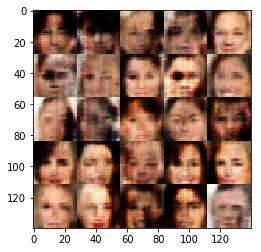

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.3378
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.2527
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 1.8965
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.6016


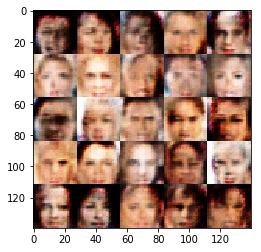

Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.9223
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 1.7396
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 2.8754
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 0.2289... Generator Loss: 2.6260
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 0.2731... Generator Loss: 1.9240


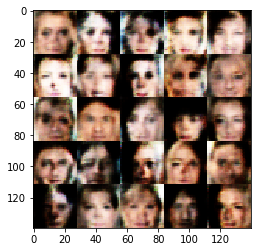

Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 0.2582... Generator Loss: 3.2506
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 2.7876
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 1.5678
Epoch 1/1... Discriminator Loss: 1.8044... Generator Loss: 2.4342
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 3.5908
Epoch 1/1... Discriminator Loss: 0.2757... Generator Loss: 2.3069
Epoch 1/1... Discriminator Loss: 0.2799... Generator Loss: 2.2082
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.2687... Generator Loss: 1.9415


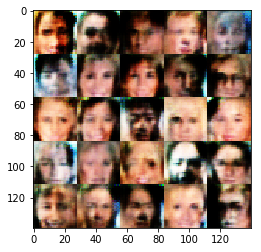

Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.4862
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.8708... Generator Loss: 0.2455
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.2992
Epoch 1/1... Discriminator Loss: 1.8790... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.7473... Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 1.7845
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0411


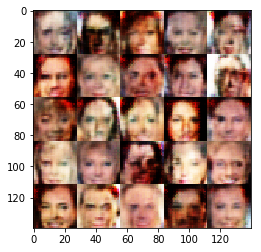

Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 2.4880... Generator Loss: 0.1497
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 2.3192
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 2.6299


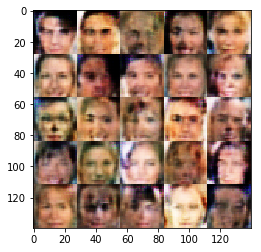

Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.2192... Generator Loss: 5.0875
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.3161
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 2.1562


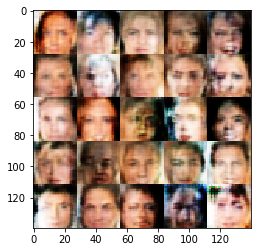

Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.7230... Generator Loss: 0.2605
Epoch 1/1... Discriminator Loss: 0.2110... Generator Loss: 3.2120
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.8990
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 0.8753


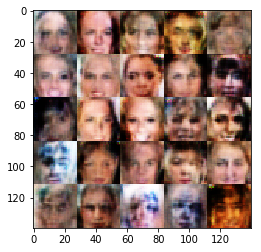

Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 3.1384
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.8562
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 1.8919... Generator Loss: 0.1996
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.4010


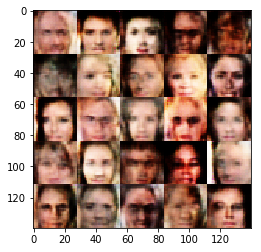

Epoch 1/1... Discriminator Loss: 1.7856... Generator Loss: 0.2392
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 3.4631... Generator Loss: 4.1485
Epoch 1/1... Discriminator Loss: 0.3232... Generator Loss: 2.0662
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.6337... Generator Loss: 0.3151
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 2.4116... Generator Loss: 0.1202
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4328


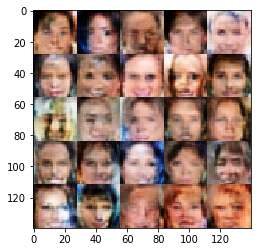

Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 1.9242... Generator Loss: 0.2168
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 1.7865


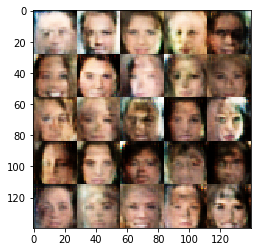

Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.0961


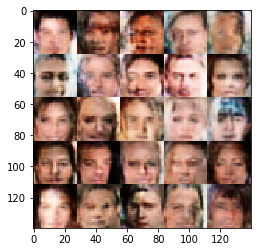

Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.2094... Generator Loss: 2.7149
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.9810
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 1.4384


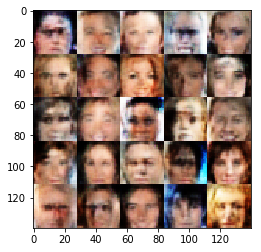

Epoch 1/1... Discriminator Loss: 1.8621... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.9728... Generator Loss: 0.1965
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.5342


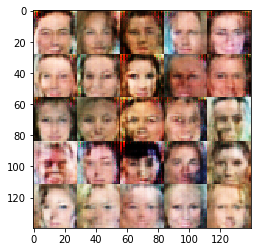

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.2851
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 2.0736... Generator Loss: 0.2107
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.5286


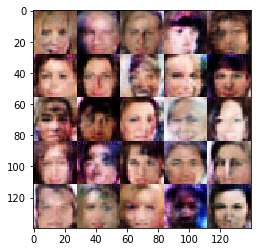

Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 2.3350... Generator Loss: 0.1613
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.8970


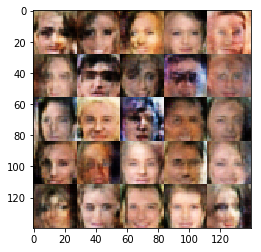

Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 2.0710
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.7898
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.3947


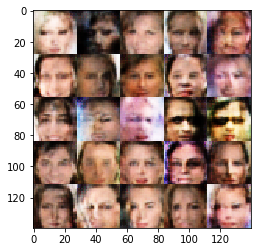

Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 2.0630... Generator Loss: 0.1787
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.3891


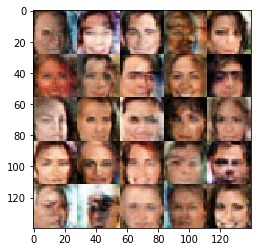

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.9108
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.4858


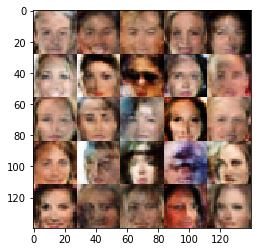

Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.2849
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.3808


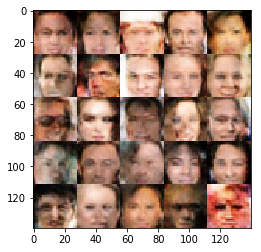

Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 0.9132


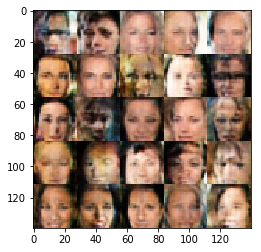

Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.8510... Generator Loss: 0.2461
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.8626


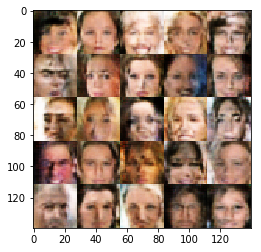

Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 2.0322
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.6052


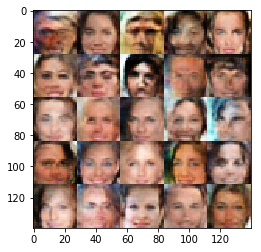

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 2.6732


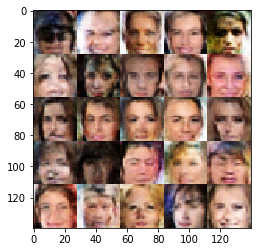

Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.3110


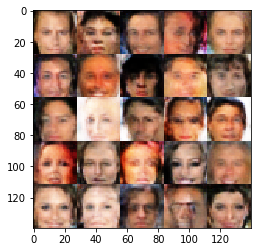

Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.4915


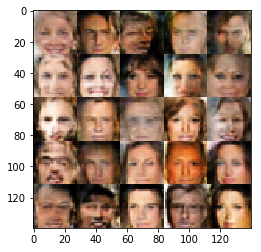

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 1.7200... Generator Loss: 1.9642
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.4521


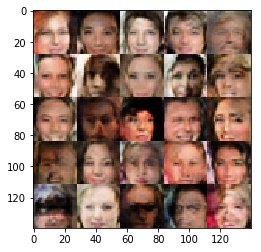

Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.2501


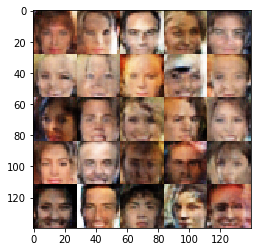

Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.7384... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.3764
Epoch 1/1... Discriminator Loss: 1.8319... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.3345
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.0257


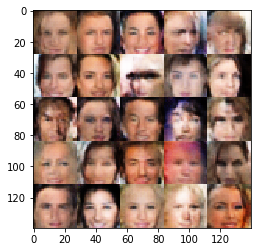

Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.9476... Generator Loss: 0.2485
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.6474


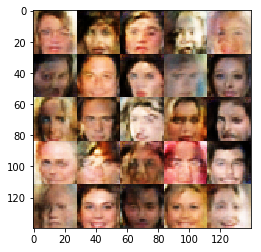

Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 2.1322
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.8961


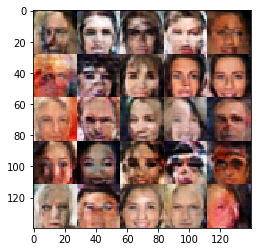

Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0294


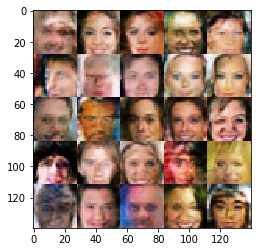

Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.2658
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.2584
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.4275
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 1.9331... Generator Loss: 0.2043
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.4572


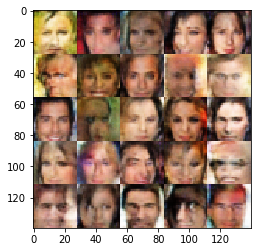

Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.2241


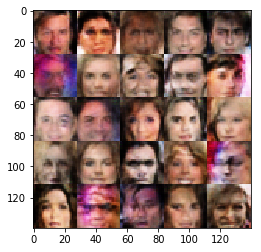

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7668


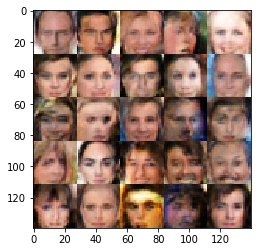

Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 2.0342... Generator Loss: 0.2640
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 0.9395


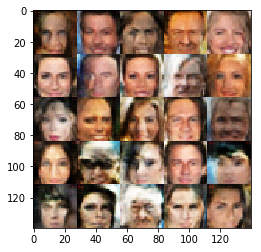

Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.6668


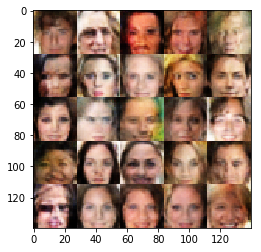

Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 0.8689


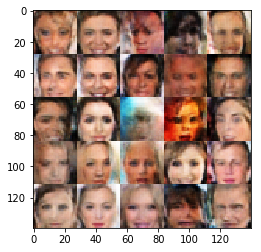

Epoch 1/1... Discriminator Loss: 1.8636... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.3260
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.9642... Generator Loss: 0.1819
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.7054... Generator Loss: 0.2641


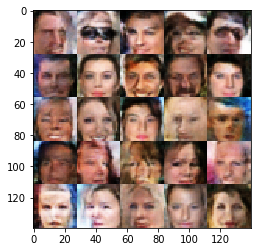

Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.4678


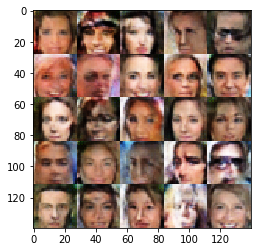

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 0.2587
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.4599


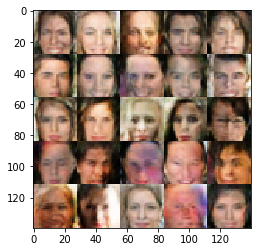

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.2826
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.3365


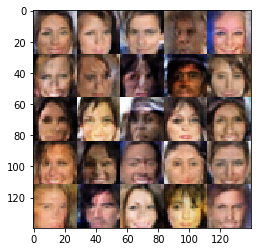

Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.4363


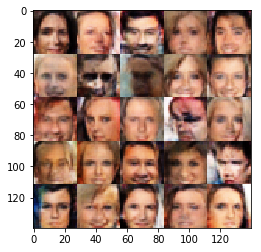

Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.3351
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.3954


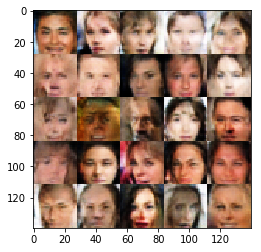

Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.3791


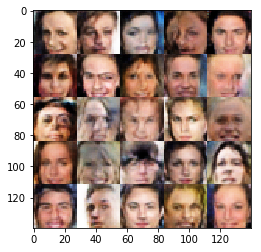

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.5059


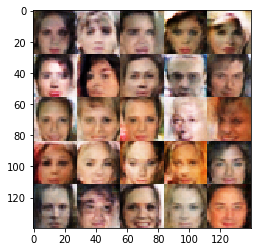

Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7193


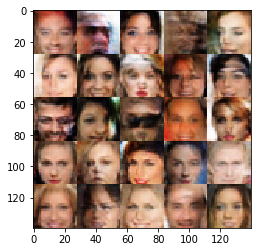

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 0.9571


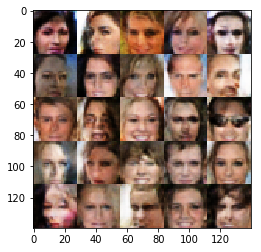

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.7675... Generator Loss: 0.2451
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.4250


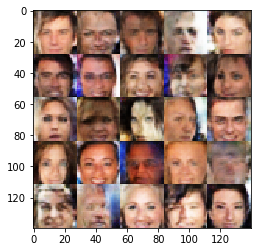

Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.3577
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.2564


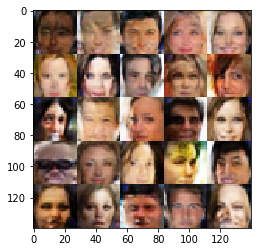

Epoch 1/1... Discriminator Loss: 1.7683... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.1145


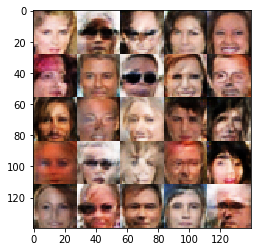

Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.5817


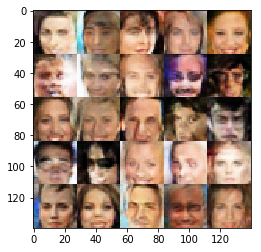

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7706


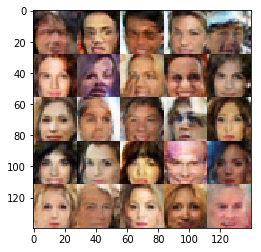

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.3061
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4825
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5914


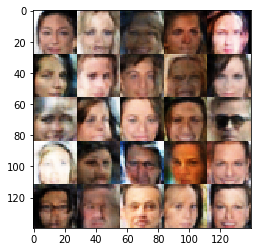

Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.4728


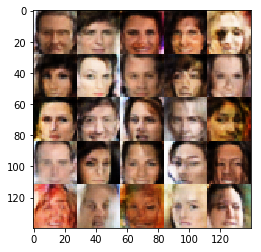

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 0.3093
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1572


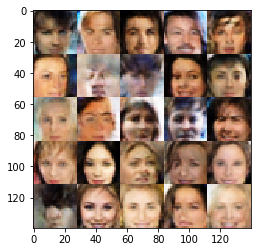

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.4595


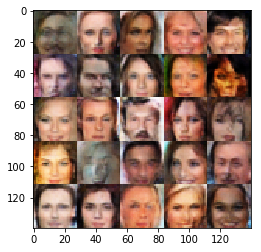

Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 0.3138


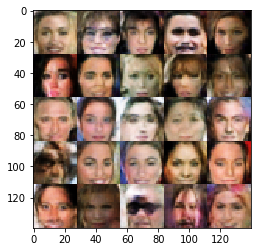

Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 0.2785
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.8017... Generator Loss: 0.2270
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8070


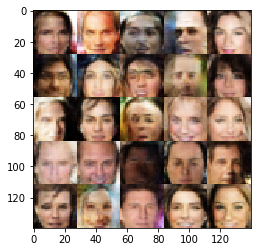

Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7479


In [78]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.